# Notebook pour algo CRA Bretagne

Problématique du Hackathon
Comment anticiper et réduire la pression des adventices dans les parcelles agricoles bretonnes, dans un contexte de réduction progressive des herbicides, en s’appuyant sur l’analyse des données historiques, climatiques et agronomiques, afin d’identifier les parcelles les plus adaptées à la culture de plantes sensibles comme le pois ou le haricot sur les trois prochaines années ?

🔍 Objectif spécifique du modèle de simulation
Prédire la pression adventice sur chaque parcelle pour les 3 prochaines campagnes.
Identifier les parcelles à faible risque pour y implanter des cultures sensibles (ex. : pois, haricot).
Intégrer les données climatiques, historiques d’intervention, rotations, rendements et IFT.
Proposer des alternatives techniques en cas de retrait de certaines molécules herbicides.

## Imports

In [3]:
# Core data analysis libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import lightgbm as lgb

# Geospatial analysis (for agricultural parcels)
try:
    import geopandas as gpd
    import folium
    GEOSPATIAL_AVAILABLE = True
except ImportError:
    GEOSPATIAL_AVAILABLE = False
    print("Geospatial libraries not available. Some features may be limited.")

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# Utility libraries
import os
import json
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"🤖 Scikit-learn available")
print(f"🚀 XGBoost version: {xgb.__version__}")
print(f"🌍 Geospatial libraries: {'Available' if GEOSPATIAL_AVAILABLE else 'Not available'}")


✅ All libraries imported successfully!
📊 Pandas version: 2.3.2
🔢 NumPy version: 2.3.3
🤖 Scikit-learn available
🚀 XGBoost version: 3.0.5
🌍 Geospatial libraries: Available


## 📊 Chargement et exploration des données

Nous allons charger et analyser les données d'interventions agricoles de la Station Expérimentale de Kerguéhennec pour prédire la pression des adventices.


In [8]:
# Chargement des données
data_path = "data/Interventions-(sortie-excel)-Station_Expérimentale_de_Kerguéhennec-2025.csv"

# Lire le fichier CSV en sautant la première ligne qui contient le titre
df = pd.read_csv(data_path, skiprows=1)

print(f"📋 Dimensions du dataset: {df.shape}")
print(f"📅 Période couverte: {df['millesime'].min()} - {df['millesime'].max()}")
print(f"🌾 Nombre de parcelles uniques: {df['numparcell'].nunique()}")
print(f"🏢 Station: {df['raisonsoci'].iloc[0]}")

# Affichage des premières lignes
print("\n📋 Aperçu des données:")
df.head()


📋 Dimensions du dataset: (653, 34)
📅 Période couverte: 2025 - 2025
🌾 Nombre de parcelles uniques: 45
🏢 Station: Station Expérimentale de Kerguéhennec

📋 Aperçu des données:


millesime                             raisonsoci           siret    pacage  \
0       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
1       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
2       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
3       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
4       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   

      refca  numilot  numparcell       nomparc  surfparc  rang  ...  kqte  \
0  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
1  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
2  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
3  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
4  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   

  teneurn teneurp teneurk  keq volumebo    codeamm  codegnis  \
0     NaN     NaN     NaN  NaN      NaN  9100296.0       NaN   
1     NaN     NaN     NaN  NaN      NaN        NaN       NaN   
2     NaN     NaN     NaN  NaN      NaN        NaN       NaN   
3     NaN     NaN     NaN  NaN      NaN        NaN   512E355   
4     NaN     NaN     NaN  NaN      NaN        NaN   512D830   

                                            materiel mainoeuvre  
0  PULVERISATEURS, Pulvérisateur ARLAND Hélium + ...        NaN  
1  TRACTEURS CLASSIQUES, Tracteur JOHN DEERE 6R15...        NaN  
2  CULTIVATEURS ET CHISELS, Canadien AMAZONE Ceni...        NaN  
3  TASSE-AVANT, Tasse-avant 3m LABBE ROTIEL Roll-...        NaN  
4  TASSE-AVANT, Tasse-avant 3m LABBE ROTIEL Roll-...        NaN  

[5 rows x 34 columns]

## 🔍 Analyse exploratoire approfondie des données

### Structure générale du dataset


In [9]:
# 1. EXPLORATION GÉNÉRALE DES DONNÉES
print("="*80)
print("📊 ANALYSE EXPLORATOIRE COMPLÈTE - DONNÉES AGRICOLES KERGUÉHENNEC")
print("="*80)

# Informations de base
print(f"\n📋 Informations générales:")
print(f"   • Nombre d'observations: {df.shape[0]:,}")
print(f"   • Nombre de variables: {df.shape[1]}")
print(f"   • Taille mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Aperçu de la structure
print(f"\n📊 Colonnes du dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

# Types de données
print(f"\n🔢 Types de données:")
type_counts = df.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"   • {dtype}: {count} colonnes")

# Valeurs manquantes
print(f"\n❓ Valeurs manquantes:")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
if len(missing_data) > 0:
    for col, count in missing_data.items():
        pct = (count / len(df)) * 100
        print(f"   • {col}: {count} ({pct:.1f}%)")
else:
    print("   ✅ Aucune valeur manquante détectée")

# Statistiques descriptives pour les colonnes numériques
print(f"\n📈 Colonnes numériques:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"   {len(numeric_cols)} colonnes numériques identifiées")
for col in numeric_cols:
    print(f"   • {col}")

print(f"\n📋 Aperçu des 10 premières lignes:")
df.head(10)


📊 ANALYSE EXPLORATOIRE COMPLÈTE - DONNÉES AGRICOLES KERGUÉHENNEC

📋 Informations générales:
   • Nombre d'observations: 653
   • Nombre de variables: 34
   • Taille mémoire: 0.71 MB

📊 Colonnes du dataset:
    1. millesime
    2. raisonsoci
    3. siret
    4. pacage
    5. refca
    6. numilot
    7. numparcell
    8. nomparc
    9. surfparc
   10. rang
   11. estpac
   12. libelleusag
   13. datedebut
   14. datefin
   15. libperiode
   16. libregroupe
   17. libevenem
   18. dureeeffect
   19. familleprod
   20. produit
   21. quantitetot
   22. unite
   23. neffqte
   24. peffqte
   25. kqte
   26. teneurn
   27. teneurp
   28. teneurk
   29. keq
   30. volumebo
   31. codeamm
   32. codegnis
   33. materiel
   34. mainoeuvre

🔢 Types de données:
   • object: 13 colonnes
   • float64: 13 colonnes
   • int64: 7 colonnes
   • bool: 1 colonnes

❓ Valeurs manquantes:
   • libperiode: 653 (100.0%)
   • keq: 629 (96.3%)
   • peffqte: 583 (89.3%)
   • teneurk: 583 (89.3%)
   • teneurp: 58

millesime                             raisonsoci           siret    pacage  \
0       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
1       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
2       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
3       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
4       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
5       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
6       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
7       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
8       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   
9       2025  Station Expérimentale de Kerguéhennec  18560001000016  56021200   

      refca  numilot  numparcell       nomparc  surfparc  rang  ...  kqte  \
0  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
1  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
2  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
3  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
4  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
5  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
6  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
7  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
8  70000308        1          12  Etang Milieu      2.28     1  ...   NaN   
9  70000308        1          12  Etang Milieu      2.28     1  ...   0.0   

  teneurn teneurp teneurk  keq volumebo    codeamm  codegnis  \
0     NaN     NaN     NaN  NaN      NaN  9100296.0       NaN   
1     NaN     NaN     NaN  NaN      NaN        NaN       NaN   
2     NaN     NaN     NaN  NaN      NaN        NaN       NaN   
3     NaN     NaN     NaN  NaN      NaN        NaN   512E355   
4     NaN     NaN     NaN  NaN      NaN        NaN   512D830   
5     NaN     NaN     NaN  NaN      NaN  2160226.0       NaN   
6     NaN     NaN     NaN  NaN    150.0  2080145.0       NaN   
7     NaN     NaN     NaN  NaN    100.0  2140235.0       NaN   
8     NaN     NaN     NaN  NaN    100.0  2080123.0       NaN   
9    33.5     0.0     0.0  NaN      NaN        NaN       NaN   

                                            materiel mainoeuvre  
0  PULVERISATEURS, Pulvérisateur ARLAND Hélium + ...        NaN  
1  TRACTEURS CLASSIQUES, Tracteur JOHN DEERE 6R15...        NaN  
2  CULTIVATEURS ET CHISELS, Canadien AMAZONE Ceni...        NaN  
3  TASSE-AVANT, Tasse-avant 3m LABBE ROTIEL Roll-...        NaN  
4  TASSE-AVANT, Tasse-avant 3m LABBE ROTIEL Roll-...        NaN  
5  QUADS, Quad POLARIS 500 cc - DISTRIBUTEUR ENGR...        NaN  
6  PULVERISATEURS, Pulvérisateur ARLAND Hélium + ...        NaN  
7  PULVERISATEURS, Pulvérisateur ARLAND Hélium + ...        NaN  
8  PULVERISATEURS, Pulvérisateur ARLAND Hélium + ...        NaN  
9  TRACTEURS CLASSIQUES, Tracteur CLAAS Arion 440...        NaN  

[10 rows x 34 columns]

### 🌾 Analyse des parcelles agricoles


In [10]:
# 2. ANALYSE DES PARCELLES
print("="*50)
print("🌾 ANALYSE DES PARCELLES AGRICOLES")
print("="*50)

# Informations sur les parcelles
print(f"\n📊 Répartition des parcelles:")
print(f"   • Nombre total de parcelles: {df['numparcell'].nunique()}")
print(f"   • Surface totale couverte: {df['surfparc'].sum():.2f} hectares")
print(f"   • Surface moyenne par parcelle: {df['surfparc'].mean():.2f} hectares")
print(f"   • Surface médiane par parcelle: {df['surfparc'].median():.2f} hectares")

# Analyse par parcelle avec leurs caractéristiques
parcel_summary = df.groupby(['numparcell', 'nomparc']).agg({
    'surfparc': 'first',
    'libelleusag': 'first',  # Culture principale
    'millesime': 'count',    # Nombre d'interventions
    'libevenem': lambda x: len(x.unique()),  # Types d'événements
    'familleprod': lambda x: len(x.dropna().unique()),  # Types de produits
    'quantitetot': 'sum'     # Quantité totale utilisée
}).round(2)

parcel_summary.columns = ['Surface_ha', 'Culture', 'Nb_interventions', 'Types_evenements', 'Types_produits', 'Quantite_totale']
parcel_summary = parcel_summary.sort_values('Surface_ha', ascending=False)

print(f"\n📋 Top 10 des parcelles par surface:")
print(parcel_summary.head(10))

# Répartition des cultures
print(f"\n🌱 Répartition des cultures:")
culture_repartition = df['libelleusag'].value_counts()
for culture, count in culture_repartition.items():
    pct = (count / len(df)) * 100
    print(f"   • {culture}: {count} interventions ({pct:.1f}%)")

# Analyse des surfaces par culture
surface_par_culture = df.groupby('libelleusag')['surfparc'].agg(['sum', 'mean', 'count']).round(2)
surface_par_culture.columns = ['Surface_totale_ha', 'Surface_moyenne_ha', 'Nb_parcelles']
print(f"\n📏 Surfaces par type de culture:")
print(surface_par_culture)

# Statistiques des surfaces
print(f"\n📊 Statistiques des surfaces de parcelles:")
surface_stats = df['surfparc'].describe()
for stat, value in surface_stats.items():
    print(f"   • {stat}: {value:.2f} ha")


🌾 ANALYSE DES PARCELLES AGRICOLES

📊 Répartition des parcelles:
   • Nombre total de parcelles: 45
   • Surface totale couverte: 1183.03 hectares
   • Surface moyenne par parcelle: 1.81 hectares
   • Surface médiane par parcelle: 0.98 hectares

📋 Top 10 des parcelles par surface:
                                 Surface_ha                 Culture  \
numparcell nomparc                                                    
1102       Bourg bas                   6.73        blé tendre hiver   
1301       Bois Guillemin              5.97        blé tendre hiver   
1101       Bourg Haut                  5.55              maïs grain   
1001       Carancier Ht                5.46             colza hiver   
48         Etang Bois                  3.36  haricot vert industrie   
44         La Défriche                 3.25             CIPAN autre   
2          Kersuzan Bas                3.05             CIPAN autre   
81          Charbonnerie Entrée        3.01             CIPAN autre   
11       

### 🧪 Analyse des interventions herbicides (focus sur les adventices)


In [11]:
# 3. ANALYSE FOCUS HERBICIDES ET ADVENTICES
print("="*60)
print("🧪 ANALYSE DES INTERVENTIONS HERBICIDES - PRESSION ADVENTICES")
print("="*60)

# Filtrer les interventions herbicides
herbicides_df = df[df['familleprod'] == 'Herbicides'].copy()

print(f"\n📊 Statistiques générales herbicides:")
print(f"   • Total interventions herbicides: {len(herbicides_df)}")
print(f"   • Pourcentage du dataset: {(len(herbicides_df)/len(df)*100):.1f}%")
print(f"   • Parcelles traitées: {herbicides_df['numparcell'].nunique()}")
print(f"   • Produits herbicides utilisés: {herbicides_df['produit'].nunique()}")

# Analyse des types d'événements herbicides
print(f"\n🎯 Types d'événements herbicides:")
herbicide_events = herbicides_df['libevenem'].value_counts()
for event, count in herbicide_events.items():
    pct = (count / len(herbicides_df)) * 100
    print(f"   • {event}: {count} ({pct:.1f}%)")

# Produits herbicides les plus utilisés
print(f"\n🧪 Top 10 des produits herbicides:")
top_herbicides = herbicides_df['produit'].value_counts().head(10)
for produit, count in top_herbicides.items():
    # Calculer la quantité totale pour ce produit
    qty_total = herbicides_df[herbicides_df['produit'] == produit]['quantitetot'].sum()
    print(f"   • {produit}: {count} applications, {qty_total:.2f} L/Kg total")

# Analyse par parcelle - Intensité herbicide
herbicide_intensity = herbicides_df.groupby(['numparcell', 'nomparc', 'libelleusag']).agg({
    'quantitetot': 'sum',        # Quantité totale herbicide
    'datedebut': 'count',        # Nombre d'applications
    'produit': lambda x: len(x.unique()),  # Nombre de produits différents
    'surfparc': 'first'          # Surface de la parcelle
}).round(2)

herbicide_intensity.columns = ['Quantite_totale', 'Nb_applications', 'Nb_produits_diff', 'Surface_ha']

# Calculer l'intensité par hectare
herbicide_intensity['Intensite_par_ha'] = (herbicide_intensity['Quantite_totale'] / 
                                         herbicide_intensity['Surface_ha']).round(2)

herbicide_intensity = herbicide_intensity.sort_values('Intensite_par_ha', ascending=False)

print(f"\n📈 Top 10 parcelles avec plus forte intensité herbicide (quantité/ha):")
print(herbicide_intensity.head(10))

# Analyse temporelle des traitements herbicides
herbicides_df['datedebut'] = pd.to_datetime(herbicides_df['datedebut'], format='%d/%m/%y', errors='coerce')
herbicides_df['mois'] = herbicides_df['datedebut'].dt.month
herbicides_df['jour_annee'] = herbicides_df['datedebut'].dt.dayofyear

print(f"\n📅 Répartition temporelle des traitements herbicides:")
monthly_herbicides = herbicides_df['mois'].value_counts().sort_index()
mois_noms = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
for mois, count in monthly_herbicides.items():
    if pd.notna(mois):
        print(f"   • {mois_noms[int(mois)-1]}: {count} traitements")

# Corrélation surface/intensité herbicide
print(f"\n🔗 Analyse de corrélation:")
if len(herbicide_intensity) > 1:
    corr_surface_intensite = herbicide_intensity['Surface_ha'].corr(herbicide_intensity['Intensite_par_ha'])
    print(f"   • Corrélation Surface vs Intensité herbicide: {corr_surface_intensite:.3f}")
    
    corr_surface_applications = herbicide_intensity['Surface_ha'].corr(herbicide_intensity['Nb_applications'])
    print(f"   • Corrélation Surface vs Nb applications: {corr_surface_applications:.3f}")


🧪 ANALYSE DES INTERVENTIONS HERBICIDES - PRESSION ADVENTICES

📊 Statistiques générales herbicides:
   • Total interventions herbicides: 103
   • Pourcentage du dataset: 15.8%
   • Parcelles traitées: 26
   • Produits herbicides utilisés: 33

🎯 Types d'événements herbicides:
   • Traitement et protection des cultures: 103 (100.0%)

🧪 Top 10 des produits herbicides:
   • LUMEO: 7 applications, 1.34 L/Kg total
   • PEAK: 7 applications, 0.07 L/Kg total
   • GLISTER ULTRA 360: 6 applications, 36.73 L/Kg total
   • BISCOTO: 5 applications, 6.05 L/Kg total
   • ISARD: 5 applications, 8.07 L/Kg total
   • FREEWAY 480: 5 applications, 4.00 L/Kg total
   • NISSHIN PREMIUM 6 OD: 5 applications, 2.10 L/Kg total
   • ALABAMA: 4 applications, 3.98 L/Kg total
   • CENT-7: 4 applications, 0.62 L/Kg total
   • CORUM: 4 applications, 3.83 L/Kg total

📈 Top 10 parcelles avec plus forte intensité herbicide (quantité/ha):
                                                                Quantite_totale  \
n

### 📊 Visualisations interactives


📊 VISUALISATIONS DES DONNÉES


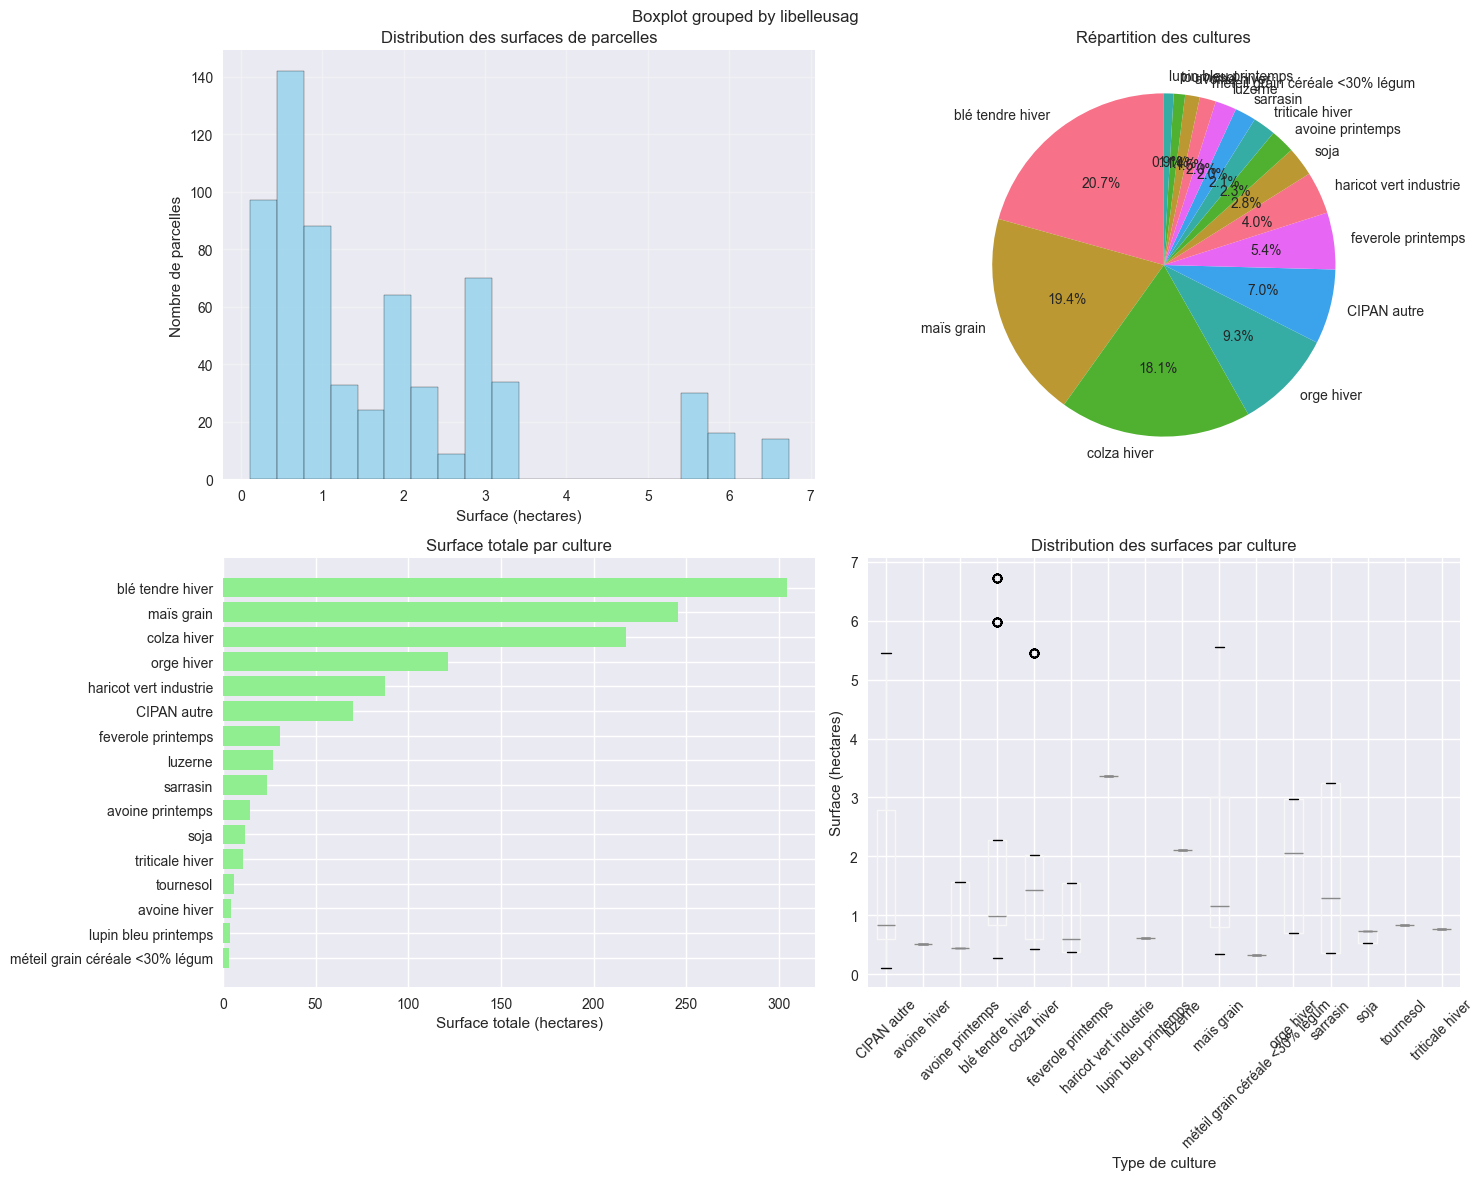

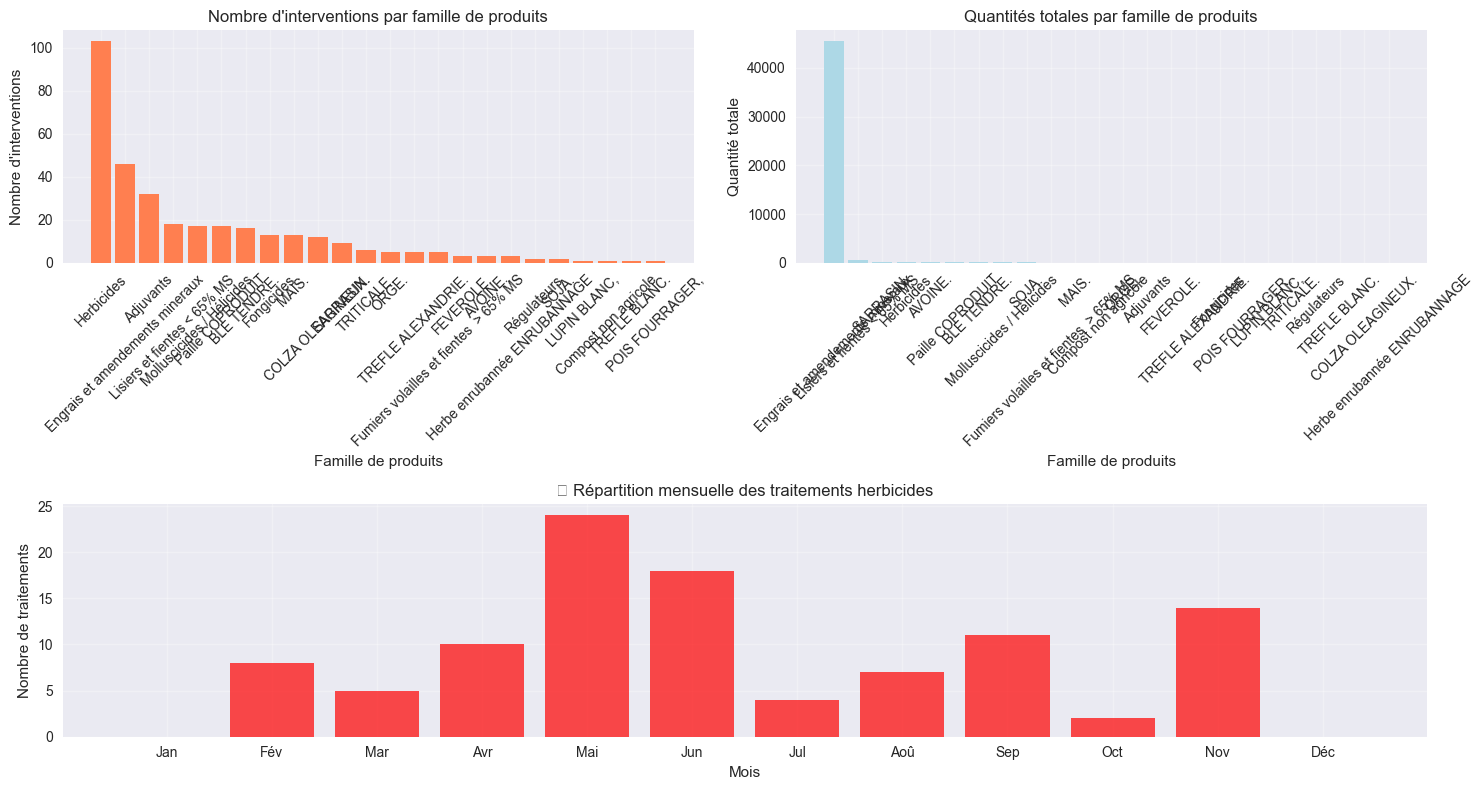

✅ Graphiques générés avec succès!


In [12]:
# 4. VISUALISATIONS INTERACTIVES
print("="*40)
print("📊 VISUALISATIONS DES DONNÉES")
print("="*40)

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (15, 10)

# 1. Distribution des surfaces de parcelles
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('📊 Analyse des Parcelles Agricoles - Station Kerguéhennec', fontsize=16, fontweight='bold')

# Histogramme des surfaces
axes[0,0].hist(df['surfparc'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution des surfaces de parcelles')
axes[0,0].set_xlabel('Surface (hectares)')
axes[0,0].set_ylabel('Nombre de parcelles')
axes[0,0].grid(True, alpha=0.3)

# Répartition des cultures
culture_counts = df['libelleusag'].value_counts()
axes[0,1].pie(culture_counts.values, labels=culture_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Répartition des cultures')

# Surface par culture
surface_par_culture = df.groupby('libelleusag')['surfparc'].sum().sort_values(ascending=True)
axes[1,0].barh(surface_par_culture.index, surface_par_culture.values, color='lightgreen')
axes[1,0].set_title('Surface totale par culture')
axes[1,0].set_xlabel('Surface totale (hectares)')

# Box plot des surfaces par culture
df.boxplot(column='surfparc', by='libelleusag', ax=axes[1,1])
axes[1,1].set_title('Distribution des surfaces par culture')
axes[1,1].set_xlabel('Type de culture')
axes[1,1].set_ylabel('Surface (hectares)')
plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 2. Analyse des interventions par famille de produits
plt.figure(figsize=(15, 8))

# Graphique 1: Nombre d'interventions par famille
plt.subplot(2, 2, 1)
family_counts = df['familleprod'].value_counts()
plt.bar(family_counts.index, family_counts.values, color='coral')
plt.title('Nombre d\'interventions par famille de produits')
plt.xlabel('Famille de produits')
plt.ylabel('Nombre d\'interventions')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Graphique 2: Quantités utilisées par famille
plt.subplot(2, 2, 2)
quantity_by_family = df.groupby('familleprod')['quantitetot'].sum().sort_values(ascending=False)
plt.bar(quantity_by_family.index, quantity_by_family.values, color='lightblue')
plt.title('Quantités totales par famille de produits')
plt.xlabel('Famille de produits')
plt.ylabel('Quantité totale')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Graphique 3: Focus herbicides - Timeline
plt.subplot(2, 1, 2)
if len(herbicides_df) > 0 and not herbicides_df['datedebut'].isna().all():
    # Compter les applications par mois
    herbicides_monthly = herbicides_df.groupby('mois').size()
    months = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
    month_data = [herbicides_monthly.get(i, 0) for i in range(1, 13)]
    
    plt.bar(months, month_data, color='red', alpha=0.7)
    plt.title('🧪 Répartition mensuelle des traitements herbicides')
    plt.xlabel('Mois')
    plt.ylabel('Nombre de traitements')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Données temporelles herbicides non disponibles', 
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Timeline des herbicides - Données manquantes')

plt.tight_layout()
plt.show()

print("✅ Graphiques générés avec succès!")


### 🎯 Indicateur de Fréquence de Traitement (IFT) et analyse des risques


In [13]:
# 5. CALCUL DE L'IFT ET ANALYSE DES RISQUES
print("="*60)
print("🎯 CALCUL IFT ET ÉVALUATION DES RISQUES ADVENTICES")
print("="*60)

# Calcul de l'IFT simplifié (approximation)
# IFT = somme des (dose appliquée / dose homologuée) pour chaque traitement

# Créer un dataset d'analyse des risques par parcelle
# D'abord, calculer les quantités d'herbicides par parcelle
herbicide_quantities = df[df['familleprod'] == 'Herbicides'].groupby(['numparcell', 'nomparc', 'libelleusag', 'surfparc'])['quantitetot'].sum().fillna(0)

# Ensuite, analyse générale par parcelle
risk_analysis = df.groupby(['numparcell', 'nomparc', 'libelleusag', 'surfparc']).agg({
    # Comptage des interventions par type
    'familleprod': lambda x: (x == 'Herbicides').sum(),  # Nb traitements herbicides
    'libevenem': lambda x: len(x.unique()),  # Diversité des événements
    'produit': lambda x: len(x.unique()),  # Diversité des produits
    'datedebut': 'count'  # Total interventions
}).round(2)

# Ajouter les quantités d'herbicides
risk_analysis['Quantite_herbicides'] = herbicide_quantities.reindex(risk_analysis.index, fill_value=0)

risk_analysis.columns = ['Nb_herbicides', 'Diversite_evenements', 'Diversite_produits', 'Total_interventions', 'Quantite_herbicides']

# Calcul d'indicateurs de risque
risk_analysis['IFT_herbicide_approx'] = (risk_analysis['Quantite_herbicides'] / 
                                        risk_analysis.index.get_level_values('surfparc')).round(2)

risk_analysis['Intensite_intervention'] = (risk_analysis['Total_interventions'] / 
                                         risk_analysis.index.get_level_values('surfparc')).round(1)

# Classification du risque adventice (basée sur l'intensité herbicide)
def classify_risk(row):
    ift = row['IFT_herbicide_approx']
    nb_herb = row['Nb_herbicides']
    
    if ift == 0 and nb_herb == 0:
        return 'TRÈS FAIBLE'  # Aucun herbicide
    elif ift < 1 and nb_herb <= 1:
        return 'FAIBLE'  # Peu d'herbicides
    elif ift < 3 and nb_herb <= 3:
        return 'MODÉRÉ'  # Usage modéré
    elif ift < 5 and nb_herb <= 5:
        return 'ÉLEVÉ'  # Usage important
    else:
        return 'TRÈS ÉLEVÉ'  # Usage intensif

risk_analysis['Risque_adventice'] = risk_analysis.apply(classify_risk, axis=1)

# Tri par risque croissant (pour identifier les parcelles favorables)
risk_order = ['TRÈS FAIBLE', 'FAIBLE', 'MODÉRÉ', 'ÉLEVÉ', 'TRÈS ÉLEVÉ']
risk_analysis['Risk_Score'] = risk_analysis['Risque_adventice'].map({r: i for i, r in enumerate(risk_order)})
risk_analysis_sorted = risk_analysis.sort_values(['Risk_Score', 'IFT_herbicide_approx'])

print(f"\n📊 Répartition des parcelles par niveau de risque adventice:")
risk_distribution = risk_analysis['Risque_adventice'].value_counts()[risk_order]
for risk_level, count in risk_distribution.items():
    pct = (count / len(risk_analysis)) * 100
    print(f"   • {risk_level}: {count} parcelles ({pct:.1f}%)")

print(f"\n🌾 TOP 10 parcelles à FAIBLE RISQUE pour cultures sensibles (pois, haricot):")
low_risk_parcels = risk_analysis_sorted.head(10)
for idx, row in low_risk_parcels.iterrows():
    parcelle, nom, culture, surface = idx
    print(f"   • Parcelle {parcelle} ({nom}): {culture}, {surface:.2f}ha")
    print(f"     - Risque: {row['Risque_adventice']}, IFT≈{row['IFT_herbicide_approx']}, {row['Nb_herbicides']} herbicides")

print(f"\n⚠️  TOP 5 parcelles à RISQUE ÉLEVÉ (surveillance prioritaire):")
high_risk_parcels = risk_analysis_sorted.tail(5)
for idx, row in high_risk_parcels.iterrows():
    parcelle, nom, culture, surface = idx
    print(f"   • Parcelle {parcelle} ({nom}): {culture}, {surface:.2f}ha")
    print(f"     - Risque: {row['Risque_adventice']}, IFT≈{row['IFT_herbicide_approx']}, {row['Nb_herbicides']} herbicides")

# Analyse par culture - Quelles cultures sont plus sensibles?
print(f"\n🌱 Analyse du risque adventice par type de culture:")
risk_by_culture = risk_analysis.reset_index().groupby('libelleusag').agg({
    'IFT_herbicide_approx': 'mean',
    'Nb_herbicides': 'mean',
    'Risque_adventice': lambda x: x.value_counts().index[0]  # Risque dominant
}).round(2)

risk_by_culture.columns = ['IFT_moyen', 'Herbicides_moyen', 'Risque_dominant']
risk_by_culture = risk_by_culture.sort_values('IFT_moyen')

for culture, row in risk_by_culture.iterrows():
    print(f"   • {culture}: IFT moyen = {row['IFT_moyen']}, Risque dominant = {row['Risque_dominant']}")

# Statistiques finales
print(f"\n📈 Statistiques IFT herbicides:")
ift_stats = risk_analysis['IFT_herbicide_approx'].describe()
for stat, value in ift_stats.items():
    print(f"   • {stat}: {value:.2f}")

# Sauvegarder les résultats pour utilisation future
risk_analysis_export = risk_analysis.reset_index()
print(f"\n💾 Données d'analyse des risques prêtes pour modélisation: {risk_analysis_export.shape[0]} parcelles analysées")


🎯 CALCUL IFT ET ÉVALUATION DES RISQUES ADVENTICES

📊 Répartition des parcelles par niveau de risque adventice:
   • TRÈS FAIBLE: 37 parcelles (55.2%)
   • FAIBLE: 8 parcelles (11.9%)
   • MODÉRÉ: 6 parcelles (9.0%)
   • ÉLEVÉ: 9 parcelles (13.4%)
   • TRÈS ÉLEVÉ: 7 parcelles (10.4%)

🌾 TOP 10 parcelles à FAIBLE RISQUE pour cultures sensibles (pois, haricot):
   • Parcelle 2 (Kersuzan Bas): CIPAN autre, 3.05ha
     - Risque: TRÈS FAIBLE, IFT≈0.0, 0 herbicides
   • Parcelle 4 (Penderff 1): CIPAN autre, 0.37ha
     - Risque: TRÈS FAIBLE, IFT≈0.0, 0 herbicides
   • Parcelle 4 (Penderff 1): feverole printemps, 0.37ha
     - Risque: TRÈS FAIBLE, IFT≈0.0, 0 herbicides
   • Parcelle 6 (Lann Chebot chemin): CIPAN autre, 0.11ha
     - Risque: TRÈS FAIBLE, IFT≈0.0, 0 herbicides
   • Parcelle 10 (Penderff 7 analytique): CIPAN autre, 1.56ha
     - Risque: TRÈS FAIBLE, IFT≈0.0, 0 herbicides
   • Parcelle 10 (Penderff 7 analytique): avoine printemps, 1.56ha
     - Risque: TRÈS FAIBLE, IFT≈0.0, 0 herb

### 📈 Graphiques avancés et tableau de bord


In [14]:
# 6. DASHBOARD INTERACTIF AVEC PLOTLY
print("="*50)
print("📈 TABLEAU DE BORD INTERACTIF")
print("="*50)

# Préparer les données pour Plotly
risk_df = risk_analysis.reset_index()

# 1. Graphique de risque par parcelle - Scatter plot interactif
fig1 = px.scatter(risk_df, 
                  x='surfparc', 
                  y='IFT_herbicide_approx',
                  color='Risque_adventice',
                  size='Nb_herbicides',
                  hover_data=['nomparc', 'libelleusag', 'Total_interventions'],
                  color_discrete_map={
                      'TRÈS FAIBLE': 'green',
                      'FAIBLE': 'lightgreen', 
                      'MODÉRÉ': 'orange',
                      'ÉLEVÉ': 'red',
                      'TRÈS ÉLEVÉ': 'darkred'
                  },
                  title="🎯 Analyse du Risque Adventice par Parcelle",
                  labels={
                      'surfparc': 'Surface de la parcelle (ha)',
                      'IFT_herbicide_approx': 'IFT Herbicide (approximatif)',
                      'Risque_adventice': 'Niveau de risque'
                  })

fig1.update_layout(
    width=900, height=600,
    title_font_size=16,
    showlegend=True
)

fig1.show()

# 2. Histogramme des niveaux de risque
risk_counts = risk_df['Risque_adventice'].value_counts()
fig2 = px.bar(x=risk_counts.index, 
              y=risk_counts.values,
              color=risk_counts.index,
              color_discrete_map={
                  'TRÈS FAIBLE': 'green',
                  'FAIBLE': 'lightgreen', 
                  'MODÉRÉ': 'orange',
                  'ÉLEVÉ': 'red',
                  'TRÈS ÉLEVÉ': 'darkred'
              },
              title="📊 Distribution des Niveaux de Risque Adventice",
              labels={'x': 'Niveau de risque', 'y': 'Nombre de parcelles'})

fig2.update_layout(width=800, height=500, showlegend=False)
fig2.show()

# 3. Heatmap de corrélation des variables clés
correlation_vars = ['surfparc', 'IFT_herbicide_approx', 'Nb_herbicides', 
                    'Total_interventions', 'Diversite_produits']
corr_matrix = risk_df[correlation_vars].corr()

fig3 = px.imshow(corr_matrix,
                 text_auto=True,
                 aspect="auto",
                 title="🔗 Matrice de Corrélation - Variables Clés",
                 color_continuous_scale="RdBu")

fig3.update_layout(width=700, height=600)
fig3.show()

# 4. Box plot par culture
fig4 = px.box(risk_df, 
              x='libelleusag', 
              y='IFT_herbicide_approx',
              color='libelleusag',
              title="📦 Distribution IFT Herbicide par Culture",
              labels={
                  'libelleusag': 'Type de culture',
                  'IFT_herbicide_approx': 'IFT Herbicide'
              })

fig4.update_layout(width=900, height=600, showlegend=False)
fig4.update_xaxes(tickangle=45)
fig4.show()

# 5. Graphique en aires empilées - Timeline des interventions (si données temporelles disponibles)
if 'datedebut' in df.columns:
    # Préparer les données temporelles
    df_temp = df.copy()
    df_temp['datedebut'] = pd.to_datetime(df_temp['datedebut'], format='%d/%m/%y', errors='coerce')
    df_temp = df_temp.dropna(subset=['datedebut'])
    
    if len(df_temp) > 0:
        df_temp['semaine'] = df_temp['datedebut'].dt.isocalendar().week
        weekly_interventions = df_temp.groupby(['semaine', 'familleprod']).size().reset_index(name='count')
        
        fig5 = px.area(weekly_interventions, 
                       x='semaine', 
                       y='count', 
                       color='familleprod',
                       title="📅 Évolution Hebdomadaire des Interventions par Famille",
                       labels={
                           'semaine': 'Semaine de l\'année',
                           'count': 'Nombre d\'interventions',
                           'familleprod': 'Famille de produits'
                       })
        
        fig5.update_layout(width=900, height=500)
        fig5.show()

print("✅ Tableau de bord interactif généré avec succès!")
print("🎯 Les graphiques permettent d'identifier visuellement:")
print("   • Les parcelles à faible risque pour cultures sensibles")
print("   • Les corrélations entre variables agricoles") 
print("   • Les patterns temporels d'intervention")
print("   • La répartition des risques par culture")


📈 TABLEAU DE BORD INTERACTIF


✅ Tableau de bord interactif généré avec succès!
🎯 Les graphiques permettent d'identifier visuellement:
   • Les parcelles à faible risque pour cultures sensibles
   • Les corrélations entre variables agricoles
   • Les patterns temporels d'intervention
   • La répartition des risques par culture
